In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Column, MaskedColumn, vstack
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.stats import median_absolute_deviation
from wcsaxes import WCSAxes
import photutils
from ccdproc import ImageFileCollection

# This can be cleaned up once psfsubtraction set a few __all__ or has import in the __init__.py files
import psfsubtraction
import psfsubtraction.fitpsftemplates
import psfsubtraction.fitpsftemplates.fitters
import psfsubtraction.fitpsftemplates.fitregion
import psfsubtraction.prepare.centering

%matplotlib inline

In [2]:
import ipyparallel

rc = ipyparallel.Client()
dview = rc[:]
lview = rc.load_balanced_view()

In [3]:
datadir = '/melkor/d1/guenther/obs/HST/Cepheids/snapshotprogram/'
outdir = '/melkor/d1/guenther/projects/Cepheids/HSTsnapshot/'

In [4]:
keys = ['TARGNAME', 'FILTER', 'ASN_ID', 'RA_TARG', 'DEC_TARG', 'DATE-OBS', 'TIME-OBS', 'EXPTIME']
fitslist = ImageFileCollection(datadir, keywords=keys)

In [5]:
fitslist.sort(['FILTER', 'TARGNAME'])

In [6]:
def read_images(filelist, halfwidth):
    '''Read files, make header wrappers for WCS'''
    images = np.ma.zeros((2 * halfwidth + 1, 2 * halfwidth + 1, len(filelist)))
    targets = []

    for i, f in enumerate(filelist):
        hdus = fits.open(f)
        xm, ym = psfsubtraction.prepare.centering.center_from_spikes(hdus[1].data)
        # Note (ym, xm), becaue ordering of axis differs!
        cutout = Cutout2D(hdus[1].data, (ym, xm), 2 * halfwidth + 1, wcs=WCS(hdus[1].header))
        hdus.close()
        targets.append(cutout)
        images[:, :, i] = cutout.data
    return images, targets


\section{Observations and data reduction}
\label{sect:obs}

We observed a sample of 70 Cepheides with the \emph{Hubble Space Telescope} using the WFC3 camera to search for binary companions. The data are described in detail in \textbf{insert reference here}. Briefly, each object was observed using two filters (\texttt{F621M} and \texttt{F845M}) which are medium bandpass filteres centered on 621~nm and 845~nm. In each filter, three dither positions were observed with exposure times of a few seconds. The exposure times are set such that the central Cepheid is overexposed by about a factor of a hundred, totally saturating the central part of its point-spread function (PSF). This is necessary to collect sufficient signal for any late-type main sequence companion. In the first paper we dealt with companions located more than 5\arcsec{} from the central source. Here, we concentrate on close companions which can be found aft5er a detailed PSF subtraction.
As described in \textbf{insert reference here}, the data are \textbf{insert what Evan did here if he did more than I say}
reduced using the standard HST/WFC3 pipeline and combined into drizzeled images. 


In [7]:
F621Marr, F621M = read_images(fitslist.files_filtered(FILTER='F621M', include_path=True), halfwidth=50)
F845Marr, F845M = read_images(fitslist.files_filtered(FILTER='F845M', include_path=True), halfwidth=50)

In [8]:
def mask_saturated(images, maskingfunc):
    '''Mask pixels above a certain value
   
    Parameters
    ----------
    image : np.array
        2d or 3d array of images (if 2d, then array of flattend images)
    maskingfunc : callable
        This function is called for every image. It returns as boolean mask
        that is ``True`` for all values that should be masked.
    '''
    for i in range(images.shape[-1]):
        images[maskingfunc(images[..., i]), i] = np.ma.masked
    return images

In [9]:
F621Marr = mask_saturated(F621Marr, lambda x: x > 0.6 * x.max())
F845Marr = mask_saturated(F845Marr, lambda x: x > 0.6 * x.max())

In [115]:
normperimF621 = np.ma.median(F621Marr.reshape((-1, F621Marr.shape[-1])), axis=0)
normperimF845 = np.ma.median(F845Marr.reshape((-1, F845Marr.shape[-1])), axis=0)

medianimF621 = np.ma.median(F621Marr.reshape((-1, F621Marr.shape[-1])), axis=1)
medianimF621 /= np.ma.median(medianimF621)
medianimF845 = np.ma.median(F845Marr.reshape((-1, F845Marr.shape[-1])), axis=1)
medianimF845 /= np.ma.median(medianimF845)

In [11]:
def apply_mediannorm(arr, normperim, normim):
    shape = arr.shape
    arr = arr.reshape((-1, shape[-1]))
    arr /= normperim[None, :]
    arr /= normim[:, None]
    return arr.reshape(shape)

def remove_mediannorm(arr, normperim, normim):
    shape = arr.shape
    arr = arr.reshape((-1, shape[-1]))
    arr *= normperim[None, :]
    arr *= normim[:, None]
    return arr.reshape(shape)

\section{PSF subtraction}

\subsection{Introduction}
referneces here

\subsection{mmm}
 - cutout based on centering based on spikes
-masking saturated pixels
- cannot transfomr bases like KLIP because of masked pixels
- fit different regions / bases


We apply two transformations to the drizzeled images in order to normalize them in a way that increases the numerical stability of the PSF fitting. After masking pixels that are saturated, we divide each image by its median value. Given the size of the images, the median value represents the power in the wings of the Cephedid PSF, so this transformation brings all iamges on a similar scale despite the different exposure times and magnituudes of the Cepheids. Second, we devide each image by the median image. Our fitting procedure is essentially a $\chi^2$ optimization with equal weights for each pixel (see below). The error term that is minimized in such a procedure it dominated the by pixels with the largest \emph{absolute} deviation. These are found in the inner part of the PSF, usually just next to the saturated pixels. However, these pixels are very uncertain for fitting the PSF, because we cannot exclude that some of them have received extra charge through bleeding. Also, our masking procedure means that those pixels are often covered by few bases only in the fit, again making the fit less reliable. By dividing each image by the median image, we ensure that the absolute numerical value in each pixel is similar, putting more weight on the other parts of the PSF.

In [12]:
normF621 = apply_mediannorm(F621Marr.copy(), normperimF621, medianimF621)
normF845 = apply_mediannorm(F845Marr.copy(), normperimF845, medianimF845)

In [13]:
def remove_img_from_psfbase(base, i):
    '''
    Parameters
    ----------
    base : np.array
        This is an array of stacked 1 or 2 d images for the bases. 
        The last dimension is the number of bases. 
    i : int, list or array of bools
        which base should be removed?
    
    Returns
    -------
    smaller_base : np.array
        Copy of base with hte specified images removed.
    '''
    ind = np.ones(base.shape[-1], dtype=bool)
    ind[i] = False
    return base[..., ind]

In [14]:
'''
Now, I run some examples with different parameters. 
I will compare them below (interactively by hand, not all plots are available in this notebook)
to determine the best parameters.

(Most of these calls can run on an engine in parallel.)
'''
# mask the bases with a stricter limit than the image data
# My idea is the following:
#    If the image data is bad, then there is nothing we can do about itb
#    but if the data in any base is bad, I can just not use that base for the pixel in question.
#    If we do us a signel bad base, that pixel is probably screwed up for the analysis, so it might be 
#    beneficial to use fewer bases when in doubt than risking a single base that is saturated.
F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .4 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
async1 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
async2 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .8 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
async3 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > 1 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
async4 = lview.map_async(lambda x: x.remove_psf(), [f])

# Now, we repeat async2, but require a minimum number of bases. This is
# - faster (because fewer regions need to be evaluated)
# - fits that use just one or two bases are probably not very good anyway, so it might be better to have those
#   regions masked than to have bogus numbers in the result.
F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction(normF621[..., 0], 
                                                                             remove_img_from_psfbase(F621_base, 0))
f.min_number_of_bases = 35
async5 = lview.map_async(lambda x: x.remove_psf(), [f])

# Repeat async2. Perform the subtraction on all pixels availble, but do *not* use the pixels
# very close to the center in the fitting.
# Because the class is defined interactively, I cannot easily ship it off to an engine.
# I can still wrap the result in a list, so that is looks the same as the async results.
import psfsubtraction.fitpsftemplates.fitregion
class fitter_except_center(psfsubtraction.fitpsftemplates.fitters.UseAllPixelsSubtraction):
    fitregion = psfsubtraction.fitpsftemplates.fitregion.wrapper_fitmask(
                        psfsubtraction.fitpsftemplates.fitregion.all_unmasked)

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = fitter_except_center(normF621[..., 0], remove_img_from_psfbase(normF621.copy(), 0))
f.fitmask = np.max(F621_stricter_masking.mask.reshape((-1, 70)), axis=1)
async6 = [f.remove_psf()]

267


<matplotlib.colorbar.Colorbar instance at 0x7f0ae062d3f8>

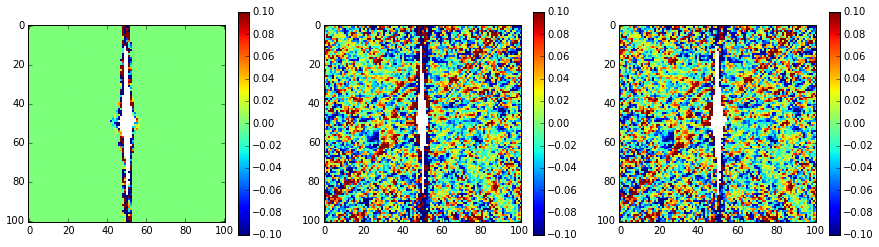

In [15]:
print len(f.regions())

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(async6[0] - async5.get()[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(132)
im2 = ax2.imshow(async6[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(133)
im3 = ax3.imshow(async5.get()[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im3, ax=ax3)
                                                                       

In [16]:
'''
Comparing the experiements above by eye, I see that there is not obvious *best* solution,
e.g. comparing results 2 and 6, I see that the one works better on the left of the Cepheid, the other one on the
right side. One is slightly better in the center, the other one on the edge of the diffraction spikes.

Obviously, the results will also be slightly different for different images, but for those examples that I looked
at by eye it holds that differenes are small and there is no best solution.
Thus, I now pick, somewhat arbitrarily the parameters that will be applied to the full dataset:

Given that we don't loose much useful data, I will set min_number_of_bases = 35 which reduces runtime by about 50%.
Also, for simplicity, we'll use the same masks for data and bases.
'''

"\nComparing the experiements above by eye, I see that there is not obvious *best* solution,\ne.g. comparing results 2 and 6, I see that the one works better on the left of the Cepheid, the other one on the\nright side. One is slightly better in the center, the other one on the edge of the diffraction spikes.\n\nObviously, the results will also be slightly different for different images, but for those examples that I looked\nat by eye it holds that differenes are small and there is no best solution.\nThus, I now pick, somewhat arbitrarily the parameters that will be applied to the full dataset:\n\nGiven that we don't loose much useful data, I will set min_number_of_bases = 35 which reduces runtime by about 50%.\nAlso, for simplicity, we'll use the same masks for data and bases.\n"

In [17]:
from psfsubtraction.fitpsftemplates.fitters import UseAllPixelsSubtraction as UAPS

# construct the initial fitter lists
def initial_fitter_list(images, psfs):
    '''Make a list of fitters
    
    Here, the psfs are assumed to contain the image data. For the fit to image[..., i], the
    psf[..., i] will be removed from the psf base.
    
    Parameters
    ----------
    images : np.array
        data to be fit (images stacked along the third dimension)
    psfs : np.array
        data to be used as psf templates (images stacked along the third dimension).
        This can, but does not have to be, different from ``imagedata``, e.g. the psfdata
        could mask more pixels.
    '''
    fitterlist = [UAPS(images[..., i], remove_img_from_psfbase(psfs, i)) for i in range(images.shape[-1])]
    for f in fitterlist:
        f.min_number_of_bases = images.shape[-1] // 2
    return fitterlist

In [18]:
asyncres621 = lview.map_async(lambda x: x.remove_psf(), initial_fitter_list(normF621, normF621))
asyncres845 = lview.map_async(lambda x: x.remove_psf(), initial_fitter_list(normF845, normF845))

In [20]:
# Check with "if" to avoid blocking the notebook when I accidentially execute this cell.
if asyncres621.ready():
    initial_fits_621 = asyncres621.get()
else:
    print "621 Not ready yet"

if asyncres845.ready():
    initial_fits_845 = asyncres845.get()
else:
    print "845 Not ready yet"

In [ ]:
reduced_images621 = remove_mediannorm(np.dstack(initial_fits_621), normperimF621, medianimF621)
reduced_images845 = remove_mediannorm(np.dstack(initial_fits_845), normperimF845, medianimF845)

       file        TARGNAME FILTER   ASN_ID  ...  DATE-OBS  TIME-OBS EXPTIME
------------------ -------- ------ --------- ... ---------- -------- -------
ibg467010_drz.fits   AH-VEL  F621M IBG467010 ... 2010-12-30 16:08:37     2.7
ibg446010_drz.fits   AP-PUP  F621M IBG446010 ... 2010-12-31 14:13:52    12.9
ibg453010_drz.fits   AP-SGR  F621M IBG453010 ... 2011-07-28 17:58:43     8.7
ibg422010_drz.fits   AV-CIR  F621M IBG422010 ... 2011-05-28 23:51:11    13.5
ibg443010_drz.fits   AW-PER  F621M IBG443010 ... 2010-10-07 05:39:27    14.4
ibg423010_drz.fits   AX-CIR  F621M IBG423010 ... 2011-07-27 05:32:37     3.3
ibg454010_drz.fits   BB-SGR  F621M IBG454010 ... 2011-08-09 03:06:07     8.7
ibg433010_drz.fits BETA-DOR  F621M IBG433010 ... 2010-10-10 14:06:03    1.44
ibg442010_drz.fits   BF-OPH  F621M IBG442010 ... 2011-05-23 22:06:39    12.3
ibg428010_drz.fits   BG-CRU  F621M IBG428010 ... 2010-10-22 06:52:12   2.085
               ...      ...    ...       ... ...        ...      ...     ...

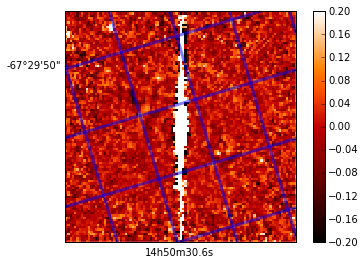

In [21]:
# Make a plot of one of the reduced datasets to compare with ds9 and check that I did not screw up the 
# coordinates somewhere -> looking at the masked values (which are unchanged in the fitting)
# this look good. 
i = 3
t = F621M[i]
print fitslist.summary[fitslist.summary['FILTER'] == 'F621M']
fig = plt.figure()
ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=t.wcs)
fig.add_axes(ax) 
im = ax.imshow(initial_fits_621[i], vmin=-.2, vmax=.2, cmap=plt.cm.gist_heat, origin='lower', interpolation='nearest')
plt.colorbar(im, ax=ax)
ra = ax.coords['ra']
dec = ax.coords['dec']
ra.grid(color='b', alpha=0.5, linestyle='solid', linewidth=3)
dec.grid(color='b', alpha=0.5, linestyle='solid', linewidth=3)
ra.set_major_formatter('hh:mm:ss.s')

In [22]:
def detect_sources(image, threshold=7, **kwargs):
    bkg_sigma = 1.48 * median_absolute_deviation(image)
    return photutils.daofind(image, threshold=7 * bkg_sigma, **kwargs)

In [177]:
daofindkwargs = {'fwhm': 1.5, 'roundlo': -0.8, 'roundhi': 0.8}
initial_sources_621 = [detect_sources(r, threshold=5, **daofindkwargs) for r in initial_fits_621]
initial_sources_845 = [detect_sources(r, threshold=5, **daofindkwargs) for r in initial_fits_845]

#initial_sources_621 = [detect_sources(r, threshold=5, **daofindkwargs) for r in np.rollaxis(reduced_images621, 2)]
#initial_sources_845 = [detect_sources(r, threshold=5, **daofindkwargs) for r in np.rollaxis(reduced_images845, 2)]

In [178]:
# Just print an example of how output source tables look and what the column names are
initial_sources_621[3]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,50.3047959054,9.79270522903,0.751136987913,0.381075255278,0.306281763179,25.0,0.0,0.439530412402,1.37781671085,-0.347978619475
2,45.8509899723,27.0327320238,0.281111962236,0.388547052359,0.485925642484,25.0,0.0,0.0206546059425,5.16350587255,-1.78236168822
3,19.4630294949,92.9552162517,0.808122603284,0.213109652367,-0.00569493645087,25.0,0.0,0.524472009688,1.3470898027,-0.323491371481


In [167]:
def check_matching_source_exists(l1, l2, d):
    '''
    
    This is not the most efficient way to to things, but very quick to code and
    runtime is not a concern for this.
    
    Parameters
    ----------
    l1, l2: two source lists
    d : float
         maximal distance in pix
    '''
    ind1 = []
    for i, s in enumerate(l1):
        dsquared = (s['xcentroid'] - l2['xcentroid'])**2 + (s['ycentroid'] - l2['ycentroid'])**2
        if np.min(dsquared) < d**2:
            ind1.append(i)
    return ind1
    
def combine_source_tables(list621, list845, names, dmax=10):
    '''Combine source tables. Input are two lists of tables in different bands.
    
    This function:
    - Only keeps sources if there is a source in the second band within ``dmax`` pixels.
    - Only keeps sources if at least one source is detected in both bands.
    - Adds a table column with the target name (form input ``names``)
    - stackes everything in one big table.
    '''
    finallist = []
    for i in range(len(list621)):
        l1 = list621[i]
        l2 = list845[i]

        if len(l1) > 0 and len(l2) > 0:
            l1 = l1[check_matching_source_exists(l1, l2, dmax)]
            if len(l1) > 0: # There are still sources left...
                l2 = l2[check_matching_source_exists(l2, l1, dmax)]
                # if there are still sources left...
                if len(l2) > 0:
                    l1['filter'] = 'F621M'
                    l2['filter'] = 'F845M'
                    l = vstack([l1, l2])
                    l['TARGNAME']= names[i]
                    finallist.append(l)
    return vstack(finallist)

In [179]:
F621names = fitslist.summary['TARGNAME'][fitslist.summary['FILTER'] == 'F621M']
F845names = fitslist.summary['TARGNAME'][fitslist.summary['FILTER'] == 'F845M']
assert np.all(F621names == F845names)
initial_sources = combine_source_tables(initial_sources_621, initial_sources_845, F621names, dmax=5)
for col in ['xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'peak', 'flux', 'mag']:
    initial_sources[col].format='4.1f'

In [180]:
initial_sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,filter,TARGNAME
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str8
2,45.9,27.0,0.3,0.4,0.5,25.0,0.0,0.0,5.2,-1.8,F621M,AV-CIR
3,19.5,93.0,0.8,0.2,-0.0,25.0,0.0,0.5,1.3,-0.3,F621M,AV-CIR
1,50.0,29.2,1.0,-0.7,-0.3,25.0,0.0,7471.1,9992.6,-10.0,F845M,AV-CIR
3,19.6,92.7,0.8,0.3,-0.2,25.0,0.0,0.6,1.2,-0.2,F845M,AV-CIR
1,48.9,50.7,0.5,-0.5,0.2,25.0,0.0,82702.2,43737.3,-11.6,F621M,AX-CIR
1,53.8,49.9,0.6,0.0,0.0,25.0,0.0,27674.5,34637.2,-11.3,F845M,AX-CIR
1,50.5,3.6,0.7,0.0,-0.6,25.0,0.0,-0.1,1.0,-0.0,F621M,BB-SGR
1,51.2,0.6,0.9,0.4,0.3,25.0,0.0,1.1,1.7,-0.6,F845M,BB-SGR
3,46.4,48.7,0.6,0.2,0.1,25.0,0.0,126497.5,168370.5,-13.1,F621M,BETA-DOR


In [136]:
def targname(n):
    n = n.replace('-', ' ')
    n = n.replace('BETA', r'$\beta$')
    n = n.replace('ZETA', r'$\zeta$')
    n = n.replace('ETA', r'$\eta$')
    n = n.replace('DEL', r'$\delta$')
    if ' ' not in n:
        n = n[:-3] + ' ' + n[-3:]
    n = n[:-2] + n[-2:].lower()
    return n

In [150]:
def plot_gallery(images, names, cutouts, sources=None, n_cols=4, n_rows=5):
    '''
    Parameters
    ----------
    images : list of 2d arrays or 3d array 
        either a list of images or a 3d array with images stacked along the last dimension
    '''
    xl, xr = 0., 0.
    yt, yb = 0., 0.

    dx = (1. - xl - xr) / n_cols
    dy = (1. - yt - yb) / n_rows

    xspacer = 0.1 * dx
    yspacer = 0.1 * dy

    fig = plt.figure(figsize=(15,20))
    for i in range(n_rows):
        for j in range(n_cols):
            index = j * n_cols + i
            x0 = xl + j * dx
            y0 = 1. - yt - (i + 1) * dy
            ax = WCSAxes(fig, [x0 + xspacer, y0 + yspacer, dx - 2 * xspacer, dy - 2 * yspacer], wcs=cutouts[index].wcs)
            fig.add_axes(ax)
            if type(images) is list:
                im = images[index]
            else:
                im = images[..., index]
            im = ax.imshow(im, cmap=plt.cm.gray, origin='lower', interpolation='nearest',
                           vmin=np.percentile(im, 5), vmax=np.percentile(im, 95))
            #plt.colorbar(im, ax=ax)
            ra = ax.coords['ra']
            dec = ax.coords['dec']
            ra.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
            dec.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
            ra.set_major_formatter('hh:mm:ss.s')
            ax.set_title(targname(names[index]))
            if sources is not None:
                # Pick different radii, otherwise one circle can cover up the circle below
                for f, color, radius in zip(['F621M', 'F845M'], ['b', 'r'], [5, 7]):
                    ind = (sources['filter'] == f) & (sources['TARGNAME'] == names[index])
                    if ind.sum() > 0:
                        apertures = photutils.CircularAperture(zip(sources['xcentroid'][ind], sources['ycentroid'][ind]), r=radius)
                        apertures.plot(color=color, lw = 3.)
    return fig

In [156]:
def plot_compare_filters(images1, cutouts1, images2, cutouts2, names, sources=None, n_rows=5):
    '''
    Parameters
    ----------
    images : list of 2d arrays or 3d array 
        either a list of images or a 3d array with images stacked along the last dimension
    '''
    xl, xr = 0., 0.
    yt, yb = 0., 0.

    n_cols = 4
    
    dx = (1. - xl - xr) / n_cols
    dy = (1. - yt - yb) / n_rows

    xspacer = 0.1 * dx
    yspacer = 0.1 * dy

    fig = plt.figure(figsize=(15,20))
    for j in range(n_rows):
        for i in range(n_cols):
            indexnumber = j * n_cols + i
            index = indexnumber // 2
            if np.mod(indexnumber, 2) == 0:
                images = images1
                cutouts = cutouts1
            else:
                images = images2
                cutouts = cutouts2
            x0 = xl + i * dx
            y0 = 1. - yt - (j + 1) * dy
            ax = WCSAxes(fig, [x0 + xspacer, y0 + yspacer, dx - 2 * xspacer, dy - 2 * yspacer], wcs=cutouts[index].wcs)
            fig.add_axes(ax)
            if type(images) is list:
                im = images[index]
            else:
                im = images[..., index]
            im = ax.imshow(im, cmap=plt.cm.gray, origin='lower', interpolation='nearest',
                           vmin=np.percentile(im, 5), vmax=np.percentile(im, 95))
            #plt.colorbar(im, ax=ax)
            ra = ax.coords['ra']
            dec = ax.coords['dec']
            ra.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
            dec.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
            ra.set_major_formatter('hh:mm:ss.s')
            ax.set_title(targname(names[index]))
            if sources is not None:
                # Pick different radii, otherwise one circle can cover up the circle below
                for f, color, radius in zip(['F621M', 'F845M'], ['b', 'r'], [5, 7]):
                    ind = (sources['filter'] == f) & (sources['TARGNAME'] == names[index])
                    if ind.sum() > 0:
                        apertures = photutils.CircularAperture(zip(sources['xcentroid'][ind], sources['ycentroid'][ind]), r=radius)
                        apertures.plot(color=color, lw = 3.)
    return fig

In [158]:
#fig = plot_gallery(initial_fits_621, F621names, F621M, initial_sources, 5, 7)

In [159]:
reduced_images = remove_mediannorm(np.dstack(initial_fits_621), normperimF621, medianimF621)

#fig = plot_gallery(reduced_images, F621names, F621M, initial_sources, 5, 7)

In [160]:
reduced_images = remove_mediannorm(np.dstack(initial_fits_845), normperimF845, medianimF845)

#fig = plot_gallery(reduced_images, F845names, F845M, initial_sources, 5, 7)

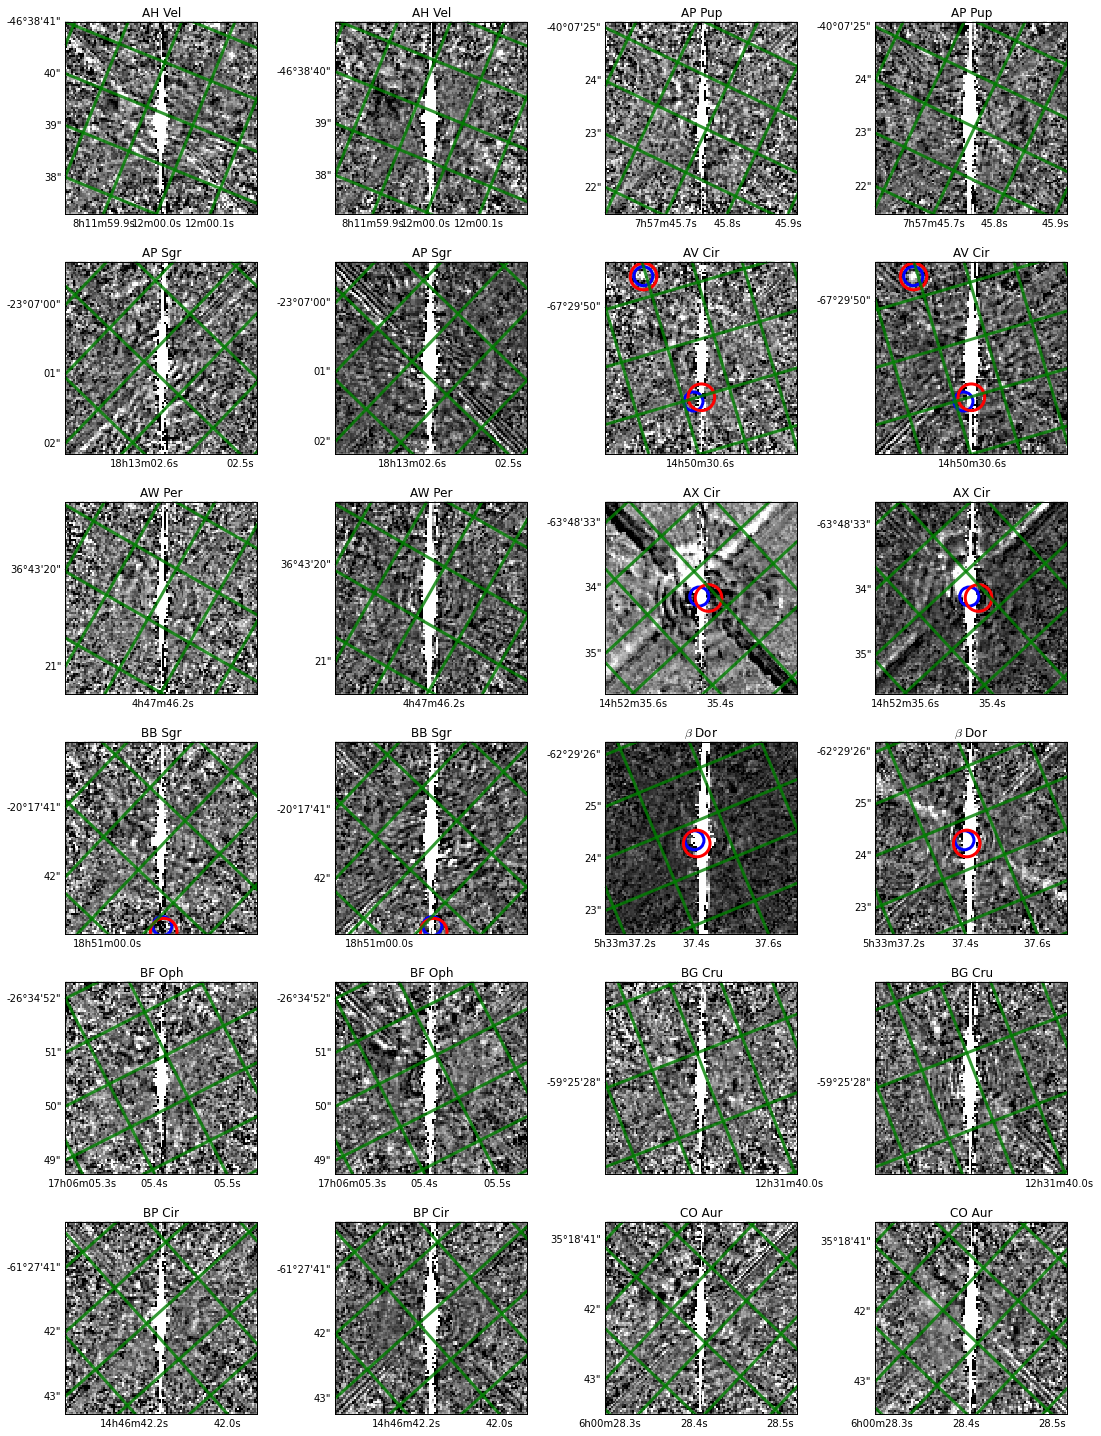

In [171]:
fig = plot_compare_filters(initial_fits_621, F621M, initial_fits_845, F845M, F621names, initial_sources, n_rows=6)

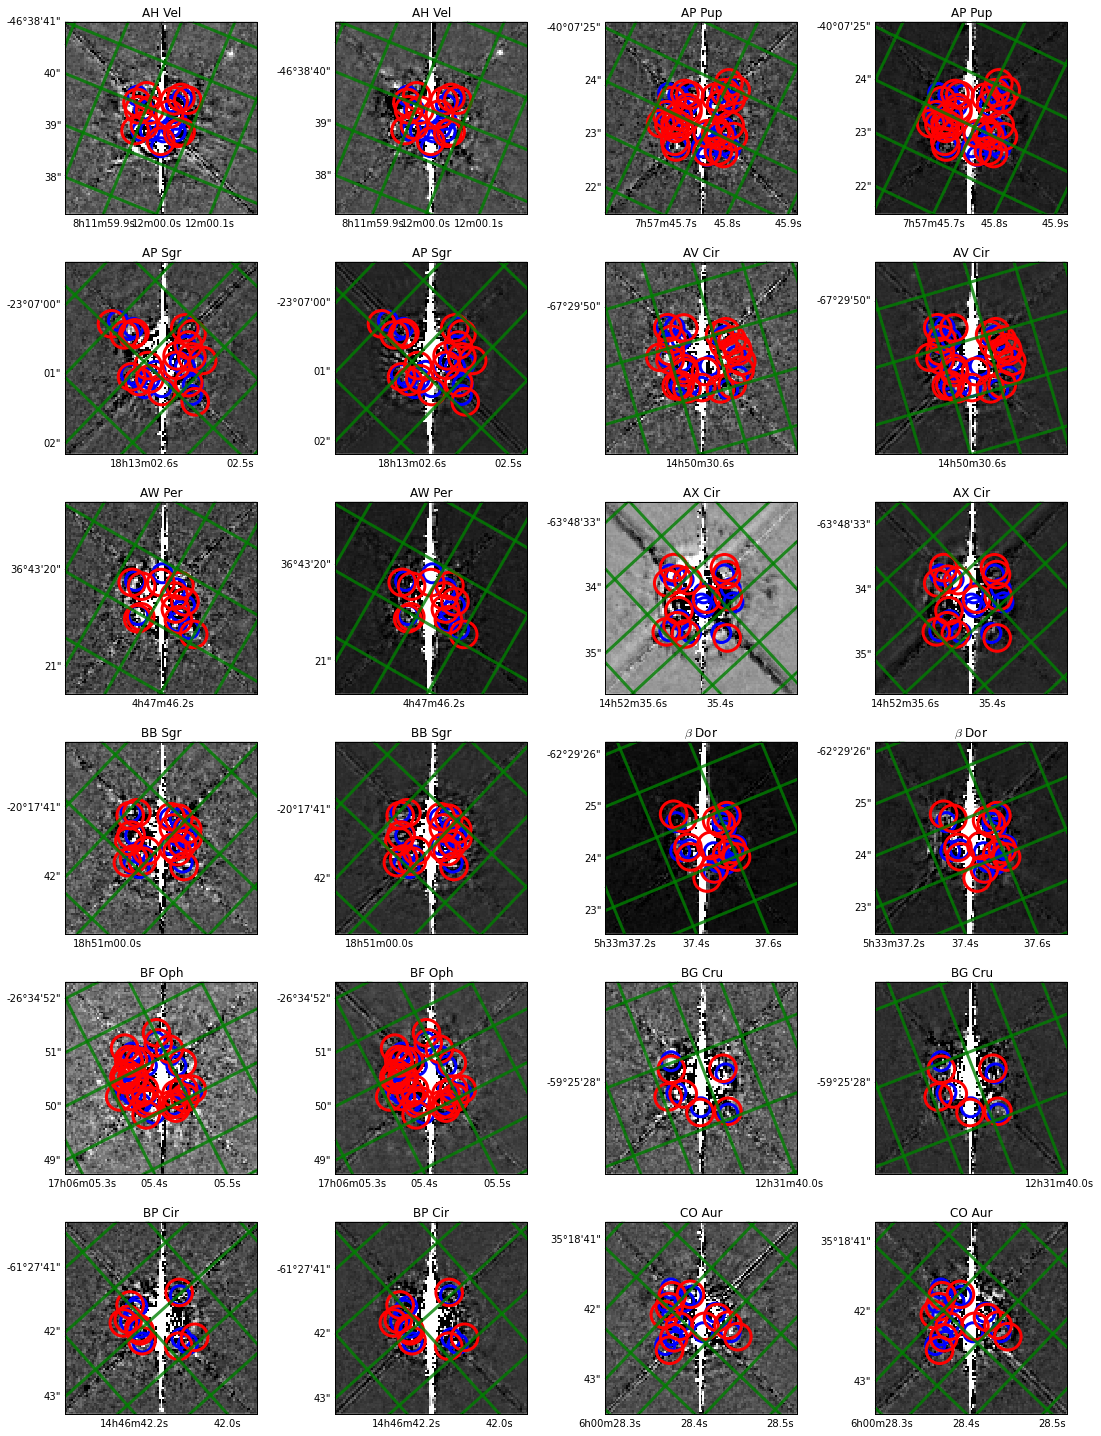

In [176]:


fig = plot_compare_filters(reduced_images621, F621M, reduced_images845, F845M, F621names, initial_sources, n_rows=6)

In [ ]:
# Why is the top right compagion in AH Vel not found?
# Why is the whooping bright AX CIR (just top left of the cepheid) not found?

# Maybe I should do the source detection on the real images, not the scales images?
# -> No. I onlt get to see PSF artifact in the middle of the images and NONE of the good compangions.

# Once that works, I'll mask the regions with detected compagnions and run through everything again.
# That should (fingers crossed!) give a better subtraction for e.g. AX Cir where the current fit is certainly distorted.

In [ ]:
# Vegamag zero points are here http://www.stsci.edu/hst/wfc3/phot_zp_lbn

# Units in image are electrons/s
# Images are drz -> drizzeled -> pixels are all same size.


def flux2magF621M(x):
    return -2.5 * np.log10(x) + 24.4539


def flux2magF845M(x):
    return -2.5 * np.log10(x) + 23.2809

In [ ]:







halfwidth = 50
daofindkwargs = {'fwhm': 1.5, 'threshold': 7, 'roundlo': -0.8, 'roundhi': 0.8}

fluxes, imout, scaledout = detection.photometryloop(images, targets, **daofindkwargs)
fluxes.add_column(MaskedColumn(flux2magF621M(fluxes['flux_fit']), 'mag_fit'))
fluxes.add_column(MaskedColumn(['F621M'] * len(fluxes), 'filter'))
#detection.plot_gallery('PSF subtr. - linear scale', imout, 10, 7, sources=fluxes)
#detection.plot_gallery('PSF subtr. - funny scale', scaledout, 10, 7, sources=fluxes)
# Get rid of negative fluxes. They must be fit artifacts
# Investigate later where they come from.
fluxes = fluxes[~fluxes['mag_fit'].mask]